In [1]:
import numpy as np
from unityagents import UnityEnvironment

In [2]:
# start the environmen
env = UnityEnvironment(file_name="C:\EigeneLokaleDaten\DeepRL\Value-based-methods\p1_navigation\Banana_Windows_x86_64\Banana.exe")
# Environments contain brains which are responsible for deciding the actions of their associated agents. 
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


In [ ]:
# run only once....
# do some statistics over the state space -> to normalize state space before input to DQN
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
states = []
for episondes in range(1000):
  env_info = env.reset(train_mode=True)[brain_name] # reset the environment
  while True:
    action = np.random.randint(action_size)        # select an action
    #action = 1        # run backwards...
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    states.append(state)
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

In [ ]:
len(states)
state.shape
states_np = np.array(states)
dx = np.zeros(state.shape[0])
for s in range(state.shape[0]):
    if np.min(states_np[:][s]) > 0: 
        dx[s] = np.max(states_np[:,s])
    else:
        if np.abs(np.max(states_np[:,s])) > np.abs(np.min(states_np[:,s])):
            dx[s] = np.abs(np.max(states_np[:,s]))
        else:
            dx[s] = np.abs(np.min(states_np[:,s]))
    print('state ',s,'min/max scaling:',np.min(states_np[:,s]),np.max(states_np[:,s]),'\t\t\t->',np.min(states_np[:,s])/dx[s],np.max(states_np[:,s])/dx[s])


In [ ]:
print(states[200][36])
#np.max(states[0:30][36])
print((states[200]))
states_np = np.array(states)
np.max(states_np[:,36])

print(states_np.shape)
print(np.max(states_np[:,36]))

scale_s = np.ones(dx.shape)
scale_s[-1] = 
scale_s[-2] = 
print(scale_s[-4:])

In [4]:
# let's start with training a DQN 
import random
import torch
import numpy as np
from collections import deque
from dqn_agent import Agent
agent = Agent(state_size=state_size, action_size=action_size, seed=42)  # 

scale_s = np.ones([37,])
scale_s[-1] = 12.42948914
scale_s[-2] = 4.15703583 
print(scale_s[-4:])

[ 1.          1.          4.15703583 12.42948914]


In [5]:
print('lets start')

def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Function adapted from DeepRL Udacity example
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        #state = env.reset()
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0] # look into the world ;) 
        state = state/scale_s
        score = 0
        for t in range(max_t):
            #action = np.random.randint(action_size-1)        # select a random  action
            action = agent.act(state, eps)    # DQN agent action selection 
  
            if action == 1:  # just forward and turn left 
                action_env = 2  
            else:
                action_env = 0
            #next_state, reward, done, _ = env.step(action)
            env_info = env.step(int(action_env))[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            next_state = next_state/scale_s
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished            
            
            #print(action)
            agent.step(state, action, reward, next_state, done)  # agent performs step 
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_Normal_scaled.pth')
            break
    return scores

scores = dqn()

print('\nsave anyway...')
torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_whatever2.pth')

# plot the scores
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

lets start
USE Double-DQN
Episode 100	Average Score: 0.75
Episode 200	Average Score: 2.95
Episode 300	Average Score: 6.64
Episode 400	Average Score: 10.63
Episode 500	Average Score: 11.43
Episode 600	Average Score: 11.83
Episode 700	Average Score: 12.67
Episode 800	Average Score: 11.68
Episode 900	Average Score: 11.81
Episode 1000	Average Score: 11.95
Episode 1068	Average Score: 13.02
Environment solved in 968 episodes!	Average Score: 13.02

save anyway...


NameError: name 'plt' is not defined

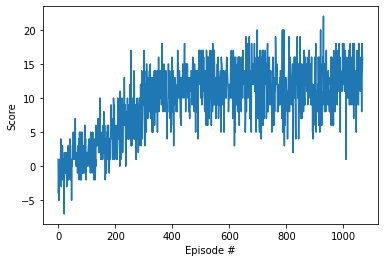

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
action
env_info = env.step(action)[brain_name] 
print(env_info.vector_observations[0])

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig, axs = plt.subplots(8, 5, sharey=True, tight_layout=True, figsize=(40, 60))
plt.rcParams.update({'font.size': 15})
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
for jj in range(5):
    for zz in range(8):
        axs[zz][jj].hist(states[:][zz+jj*8])        